# Tutorial: Using EvolveAdapter with OpenEvolve Projects

This tutorial demonstrates how to adapt an existing OpenEvolve project to work with GEPA's `EvolveAdapter`. The key changes required are providing a batch of training data and modifying your `evaluate` function to accept a **single data instance** and return an `EvaluationResult` for that data instance. The adapter then calls your evaluate function for each instance in the batch.

> **Note:** This tutorial is also available as a standalone Python script: `tutorial.py`. You can run it directly instead of using this notebook.

## Prerequisites

To run this tutorial, you need to:

1. **Clone the GEPA repository** to get the tutorial files:
   ```bash
   git clone https://github.com/gepa-ai/gepa.git
   cd gepa
   ```

2. TODO: **Install GEPA in editable mode from the root (gepa)** (required since EvolveAdapter is not in PyPI):
   ```bash
   pip install -e ".[full]"
   ```

3. **Install dependencies and input API key** using the setup cell the start of **Step 5: Using EvolveAdapter** below.

4. **Run this notebook from:** `src/gepa/examples/evolve_adapter/function_minimization/`

   This tutorial uses example files located in `src/gepa/examples/evolve_adapter/function_minimization/`:
   - `tutorial.ipynb` (this notebook)
   - `tutorial.py` (standalone Python script)
   - `tutorial_example/` (example OpenEvolve project containing `config.yaml`, `evaluator.py`, and `initial_program.py`)
   
   The `tutorial_example/` directory contains a complete, working example that demonstrates the required changes.

## Why This Change?

GEPA's optimization engine works with batches of data to:
- Provide per-instance feedback for better program refinement
- Support minibatch-based optimization strategies

## Example Project: Function Minimization

We'll use the **function minimization** example from OpenEvolve [examples/function_minimization](https://github.com/algorithmicsuperintelligence/openevolve/tree/main/examples/function_minimization).

## Step 1: Key Changes Required

Here are the **two main changes** you need to make to your `evaluate` function:

### Change 1: Function Signature
**Before:**
```python
def evaluate(program_path: str) -> EvaluationResult:
```

**After:**
```python
def evaluate(program_path: str, data_instance: Any) -> EvaluationResult:
```
- Add `data_instance` parameter (can be any type - dict, string, custom object, etc.)
- For the function minimization example, we use a `dict`, but you can use whatever type best suits your original OpenEvolve project

### Change 2: Extract Parameters from Data Instance
**Before:** Hard-coded problem parameters (e.g., `GLOBAL_MIN_X = -1.704`)

**After:** Extract parameters from the data instance. The exact way you extract parameters depends on the type of `data_instance`:
```python
# If data_instance is a dict (as in our function minimization example):
GLOBAL_MIN_X = data_instance.get("global_min_x", -1.704)
GLOBAL_MIN_Y = data_instance.get("global_min_y", 0.678)
# ... etc
```

## Complete Modified Evaluate Function

Here's the complete modified evaluate function with all changes applied. For this function minimization project example, each data instance represents a different function minimization problem:

In [ ]:
# Modified evaluator.py for EvolveAdapter
# For this example, each data instance represents a different function minimization problem
#
# KEY CHANGES MADE:
# 1. Added 'data_instance' parameter to function signature (can be any type)
#    For this example, we use a dict, but you can use whatever type suits your project
# 2. Extract parameters from data_instance instead of hard-coding

import concurrent.futures
import importlib.util
import time
import traceback

import numpy as np
from openevolve.evaluation_result import EvaluationResult


def run_with_timeout(func, args=(), kwargs={}, timeout_seconds=5):
    """
    Run a function with a timeout using concurrent.futures

    Args:
        func: Function to run
        args: Arguments to pass to the function
        kwargs: Keyword arguments to pass to the function
        timeout_seconds: Timeout in seconds

    Returns:
        Result of the function or raises TimeoutError
    """
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(func, *args, **kwargs)
        try:
            return future.result(timeout=timeout_seconds)
        except concurrent.futures.TimeoutError:
            raise TimeoutError(f"Function timed out after {timeout_seconds} seconds")


def safe_float(value):
    """Convert a value to float safely."""
    try:
        return float(value)
    except (TypeError, ValueError):
        return 0.0


# CHANGE 1: Added 'data_instance' parameter
# Note: data_instance can be of any type - use whatever best suits your original project.
# For this function minimization example, we use a dict containing problem parameters
def evaluate(program_path: str, data_instance: dict) -> EvaluationResult:
    """
    Evaluate the program on a single function minimization problem.

    Args:
        program_path: Path to the program file to evaluate
        data_instance: Dict containing problem parameters:
            - 'global_min_x': Target x coordinate
            - 'global_min_y': Target y coordinate
            - 'global_min_value': Target function value
            - 'bounds': Tuple of (min, max) bounds for search space
            - 'function_name': Optional name for the function

    Returns:
        EvaluationResult for this data instance
    """
    # Load the program
    try:
        spec = importlib.util.spec_from_file_location("program", program_path)
        program = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(program)

        if not hasattr(program, "run_search"):
            return EvaluationResult(
                metrics={"combined_score": 0.0, "error": 1.0}, artifacts={"error": "Missing run_search function"}
            )
    except Exception as e:
        return EvaluationResult(
            metrics={"combined_score": 0.0, "error": 1.0},
            artifacts={"error": str(e), "traceback": traceback.format_exc()},
        )

    try:
        # CHANGE 2: Extract problem parameters from data_instance instead of hard-coding
        # In the original, these were hard-coded constants like:
        #   GLOBAL_MIN_X = -1.704
        # Now we get them from the data instance:
        GLOBAL_MIN_X = data_instance.get("global_min_x", -1.704)
        GLOBAL_MIN_Y = data_instance.get("global_min_y", 0.678)
        GLOBAL_MIN_VALUE = data_instance.get("global_min_value", -1.519)
        bounds = data_instance.get("bounds", (-5, 5))

        # Run multiple trials for this specific problem
        num_trials = 10
        x_values = []
        y_values = []
        values = []
        distances = []
        times = []
        success_count = 0

        for trial in range(num_trials):
            try:
                start_time = time.time()

                # Run the program (it should use the bounds from data_instance)
                # Note: The program may need to be modified to accept bounds as parameter
                result = run_with_timeout(program.run_search, timeout_seconds=5)

                # Handle different result formats
                if isinstance(result, tuple):
                    if len(result) == 3:
                        x, y, value = result
                    elif len(result) == 2:
                        x, y = result
                        # Calculate function value
                        value = np.sin(x) * np.cos(y) + np.sin(x * y) + (x**2 + y**2) / 20
                    else:
                        continue
                else:
                    continue

                end_time = time.time()

                # Validate results
                x = safe_float(x)
                y = safe_float(y)
                value = safe_float(value)

                if np.isnan(x) or np.isnan(y) or np.isnan(value) or np.isinf(x) or np.isinf(y) or np.isinf(value):
                    continue

                # Calculate metrics for this trial
                x_diff = x - GLOBAL_MIN_X
                y_diff = y - GLOBAL_MIN_Y
                distance_to_global = np.sqrt(x_diff**2 + y_diff**2)

                x_values.append(x)
                y_values.append(y)
                values.append(value)
                distances.append(distance_to_global)
                times.append(end_time - start_time)
                success_count += 1

            except Exception:
                continue

        # If all trials failed, return error result
        if success_count == 0:
            return EvaluationResult(
                metrics={
                    "value_score": 0.0,
                    "distance_score": 0.0,
                    "reliability_score": 0.0,
                    "combined_score": 0.0,
                    "error": 1.0,
                },
                artifacts={"error": "All trials failed"},
            )

        # Calculate aggregated metrics for this instance
        avg_value = float(np.mean(values))
        avg_distance = float(np.mean(distances))

        # Convert to scores (higher is better)
        value_score = float(1.0 / (1.0 + abs(avg_value - GLOBAL_MIN_VALUE)))
        distance_score = float(1.0 / (1.0 + avg_distance))
        reliability_score = float(success_count / num_trials)

        # Calculate combined score
        base_score = 0.5 * value_score + 0.3 * distance_score + 0.2 * reliability_score

        # Apply solution quality multiplier
        if avg_distance < 0.5:
            solution_quality_multiplier = 1.5
        elif avg_distance < 1.5:
            solution_quality_multiplier = 1.2
        elif avg_distance < 3.0:
            solution_quality_multiplier = 1.0
        else:
            solution_quality_multiplier = 0.7

        combined_score = float(base_score * solution_quality_multiplier)

        # Create artifacts
        artifacts = {
            "convergence_info": f"Converged in {num_trials} trials with {success_count} successes",
            "best_position": f"Final position: x={x_values[-1]:.4f}, y={y_values[-1]:.4f}",
            "average_distance_to_global": f"{avg_distance:.4f}",
            "search_efficiency": f"Success rate: {reliability_score:.2%}",
        }

        return EvaluationResult(
            metrics={
                "value_score": value_score,
                "distance_score": distance_score,
                "reliability_score": reliability_score,
                "combined_score": combined_score,
            },
            artifacts=artifacts,
        )

    except Exception as e:
        # Return error result for this instance
        return EvaluationResult(
            metrics={"combined_score": 0.0, "error": 1.0},
            artifacts={"error": str(e), "traceback": traceback.format_exc()},
        )

## Summary of Changes

Here's a quick reference of what changed:

| Aspect | Original | Modified for EvolveAdapter |
|--------|----------|---------------------------|
| **Function signature** | `evaluate(program_path: str)` | `evaluate(program_path: str, data_instance: Any)` |
| **Structure** | Single evaluation | Single evaluation on an explicit data instance from a larger batch of training data |
| **Parameters** | Hard-coded constants | Extracted from `data_instance` (type depends on your project) |

## Step 2: Modifying Cascade Evaluation Functions

If your project uses cascade evaluation, you must also modify your cascade evaluation functions (`evaluate_stage1`, `evaluate_stage2`, `evaluate_stage3`) to accept a single data instance and return a single EvaluationResult for that data instance, just like the main `evaluate` function.

### Example: Modified `evaluate_stage1`

**Before:**
```python
def evaluate_stage1(program_path: str) -> EvaluationResult:
    # ... evaluation logic for single instance ...
    return EvaluationResult(metrics={...}, artifacts={...})
```

**After:**
```python
def evaluate_stage1(program_path: str, data_instance: Any) -> EvaluationResult:
    # Extract parameters from data_instance if needed
    # (Extraction method depends on the type of data_instance, e.g. dict for our 
    # function minimization example)
    GLOBAL_MIN_X = data_instance.get("global_min_x", -1.704) # if dict
    # ... evaluation logic for this data instance ...
    return EvaluationResult(metrics={...}, artifacts={...})
```

### Example: Modified `evaluate_stage2`

**Before:**
```python
def evaluate_stage2(program_path: str) -> EvaluationResult:
    # Full evaluation as in the main evaluate function
    return evaluate(program_path)
```

**After:**
```python
def evaluate_stage2(program_path: str, data_instance: Any) -> EvaluationResult:
    # Full evaluation as in the main evaluate function
    return evaluate(program_path, data_instance)
```

### Key Points for Cascade Functions:

1. **Same signature pattern**: All stage functions should follow the same pattern as `evaluate`:
   - Add `data_instance` parameter (can be any type)
   - Process the single data instance and return a single `EvaluationResult` for it

2. **Error handling**: If a stage fails for a specific data instance, return an error `EvaluationResult` for that instance rather than raising an exception

## Step 3: (Optional) Modify Config System Message

You may need to modify the `system_message` in your `config.yaml` to match your newly-modified evaluation setup. For example, if your original OpenEvolve project had a hard-coded problem in the system prompt, you should remove or generalize it.

**Example for function minimization:**
- **Before (hard-coded)**: `"You are an expert programmer specializing in optimization algorithms. Your task is to improve a function minimization algorithm to find the global minimum of a complex function with many local minima. The function is f(x, y) = sin(x) * cos(y) + sin(x*y) + (x^2 + y^2)/20. Focus on improving the search_algorithm function to reliably find the global minimum, escaping local minima that might trap simple algorithms."`
- **After (generalized)**: `"You are an expert programmer specializing in optimization algorithms. Your task is to improve a function minimization algorithm to find the global minimum of a complex function with many local minima. Focus on improving the search_algorithm function to reliably find the global minimum, escaping local minima that might trap simple algorithms."`

## Step 4: Defining Training Dataset

Before using `EvolveAdapter`, you need to define your training dataset. The dataset is a list of data instances, where each instance represents a problem to evaluate your program on.

Data instances can be of any type - use whatever type best suits your original OpenEvolve project setup. The adapter simply passes each data instance to your `evaluate` function as-is.

> **Note:** You can use just one data instance in your trainset if that's more analogous to your original OpenEvolve project setup. For example, the original function minimization project evolved on one fixed problem, so using a single data instance mimics that setup.

For the function minimization example, we use dicts where each data instance contains the problem parameters:
- `global_min_x`, `global_min_y`: The target coordinates of the global minimum
- `global_min_value`: The target function value at the global minimum
- `bounds`: The search space bounds
- `function_name`: Optional name for the function

## Step 5: Using EvolveAdapter

Here is how to use `EvolveAdapter` with GEPA's optimization engine.

In [5]:
%pip install -e "../../../../../[full]"

Obtaining file:///Users/angelahe/Desktop/gepa
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for gepa (pyproject.toml) ... done
  Created wheel for gepa: filename=gepa-0.0.24-0.editable-py3-none-any.whl size=13500 sha256=2b96b0772dbd0c9be0606b40014b80c75670b258d32ae91fd0488c52bab7eb94
  Stored in directory: /private/var/folders/l_/glwc3twx7yd30d436jfkk3_00000gn/T/pip-ephem-wheel-cache-xo3azext/wheels/bd/67/b3/b2d0d0c35bae524180c6a7cd56189ab7e2aee9c47a79c049a9
Successfully built gepa
  Attempting uninstall: gepa
    Found existing installation: gepa 0.0.24
    Uninstalling gepa-0.0.24:
      Successfully uninstalled gepa-0.0.24

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Install required dependencies
%pip install gepa openevolve numpy scipy pyyaml litellm


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Run the cell below and input your API key when prompted:

In [3]:
import os

os.environ["OPENAI_API_KEY"] = input("API Key: ")

In [7]:
from pathlib import Path

from gepa import optimize
from gepa.adapters.evolve_adapter.evolve_adapter import EvolveAdapter

# Path to your modified OpenEvolve project directory
# This should contain: config.yaml, evaluator.py, initial_program.py
# For this example, we use the tutorial_example directory in the same folder as this notebook
project_path = Path("tutorial_example")

In [8]:
# Create the adapter
adapter = EvolveAdapter(path=project_path)

In [9]:
# Define training data (for this example, function minimization problems)
# Each item represents a different problem instance
# The adapter will call your evaluate function for each instance in the batch
#
# NOTE: You can use just one data instance if that's more analogous to your original
# OpenEvolve project setup. For example, the original function minimization project
# evolved on one fixed problem, so using a single data instance mimics that setup.
trainset = [
    {
        "global_min_x": -1.704,
        "global_min_y": 0.678,
        "global_min_value": -1.519,
        "bounds": (-5, 5),
        "function_name": "sin_cos_function",
    },
    # Uncomment the following to add more problem instances:
    # {
    #     "global_min_x": 0.0,
    #     "global_min_y": 0.0,
    #     "global_min_value": 0.0,
    #     "bounds": (-3, 3),
    #     "function_name": "quadratic_function"
    # },
    # Add more problem instances as needed
]

In [10]:
# Read initial program
with open(project_path / "initial_program.py") as f:
    initial_program = f.read()

# Define seed candidate (the program to evolve)
seed_candidate = {"program": initial_program}

In [16]:
# Run GEPA optimization
result = optimize(
    seed_candidate=seed_candidate,
    trainset=trainset,
    adapter=adapter,
    max_metric_calls=500,  # Budget for evaluation calls -  adjust as needed
    display_progress_bar=True,
)

Iteration 0: Base program full valset score: 1.4079332968094032 over 1 / 1 examples
Iteration 1: Selected program 0 score: 1.4079332968094032
Iteration 1: All subsample scores perfect. Skipping.
Iteration 1: Reflective mutation did not propose a new candidate
Iteration 2: Selected program 0 score: 1.4079332968094032
Iteration 2: All subsample scores perfect. Skipping.
Iteration 2: Reflective mutation did not propose a new candidate
Iteration 3: Selected program 0 score: 1.4079332968094032


Iteration 3: All subsample scores perfect. Skipping.
Iteration 3: Reflective mutation did not propose a new candidate
Iteration 4: Selected program 0 score: 1.4079332968094032


Iteration 4: All subsample scores perfect. Skipping.
Iteration 4: Reflective mutation did not propose a new candidate
Iteration 5: Selected program 0 score: 1.4079332968094032
Iteration 5: All subsample scores perfect. Skipping.
Iteration 5: Reflective mutation did not propose a new candidate
Iteration 6: Selected program 0 score: 1.4079332968094032
Iteration 6: Proposed new text for program: """Function minimization example for OpenEvolve"""
import numpy as np
import random


def search_algorithm(iterations=10000, bounds=(-5, 5), population_size=50, mutation_rate=0.1, crossover_rate=0.7):
    """
    An improved search algorithm using concepts from evolutionary computation,
    specifically a form of Genetic Algorithm with a population-based approach
    to escape local minima.

    Args:
        iterations: Number of generations to run
        bounds: Bounds for the search space (min, max)
        population_size: Number of individuals in the population
        mutation_rate: Probabi

Iteration 6: New subsample score 0.0 is not better than old score 3.347516077054268, skipping
Iteration 7: Selected program 0 score: 1.4079332968094032


Iteration 7: All subsample scores perfect. Skipping.
Iteration 7: Reflective mutation did not propose a new candidate
Iteration 8: Selected program 0 score: 1.4079332968094032
Iteration 8: All subsample scores perfect. Skipping.
Iteration 8: Reflective mutation did not propose a new candidate
Iteration 9: Selected program 0 score: 1.4079332968094032


Iteration 9: All subsample scores perfect. Skipping.
Iteration 9: Reflective mutation did not propose a new candidate
Iteration 10: Selected program 0 score: 1.4079332968094032
Iteration 10: All subsample scores perfect. Skipping.
Iteration 10: Reflective mutation did not propose a new candidate
Iteration 11: Selected program 0 score: 1.4079332968094032


Iteration 11: All subsample scores perfect. Skipping.
Iteration 11: Reflective mutation did not propose a new candidate
Iteration 12: Selected program 0 score: 1.4079332968094032
Iteration 12: All subsample scores perfect. Skipping.
Iteration 12: Reflective mutation did not propose a new candidate
Iteration 13: Selected program 0 score: 1.4079332968094032


Iteration 13: Proposed new text for program: """Function minimization example for OpenEvolve"""
import numpy as np


def search_algorithm(iterations=1000, bounds=(-5, 5), population_size=50, mutation_rate=0.1, crossover_rate=0.7):
    """
    An improved search algorithm incorporating elements of a Genetic Algorithm
    and Simulated Annealing to escape local minima.

    Args:
        iterations: Number of iterations to run
        bounds: Bounds for the search space (min, max)
        population_size: Number of individuals in the population
        mutation_rate: Probability of a gene mutating
        crossover_rate: Probability of two parents crossing over

    Returns:
        Tuple of (best_x, best_y, best_value)
    """

    def initialize_population(size, bounds):
        population_x = np.random.uniform(bounds[0], bounds[1], size)
        population_y = np.random.uniform(bounds[0], bounds[1], size)
        return population_x, population_y

    def evaluate_population(pop_x, po

Iteration 15: All subsample scores perfect. Skipping.
Iteration 15: Reflective mutation did not propose a new candidate
Iteration 16: Selected program 0 score: 1.4079332968094032
Iteration 16: All subsample scores perfect. Skipping.
Iteration 16: Reflective mutation did not propose a new candidate
Iteration 17: Selected program 0 score: 1.4079332968094032


Iteration 17: All subsample scores perfect. Skipping.
Iteration 17: Reflective mutation did not propose a new candidate
Iteration 18: Selected program 0 score: 1.4079332968094032
Iteration 18: All subsample scores perfect. Skipping.
Iteration 18: Reflective mutation did not propose a new candidate
Iteration 19: Selected program 0 score: 1.4079332968094032
Iteration 19: All subsample scores perfect. Skipping.
Iteration 19: Reflective mutation did not propose a new candidate
Iteration 20: Selected program 0 score: 1.4079332968094032


Iteration 20: All subsample scores perfect. Skipping.
Iteration 20: Reflective mutation did not propose a new candidate
Iteration 21: Selected program 0 score: 1.4079332968094032
Iteration 21: All subsample scores perfect. Skipping.
Iteration 21: Reflective mutation did not propose a new candidate
Iteration 22: Selected program 0 score: 1.4079332968094032


Iteration 22: All subsample scores perfect. Skipping.
Iteration 22: Reflective mutation did not propose a new candidate
Iteration 23: Selected program 0 score: 1.4079332968094032
Iteration 23: All subsample scores perfect. Skipping.
Iteration 23: Reflective mutation did not propose a new candidate
Iteration 24: Selected program 0 score: 1.4079332968094032
Iteration 24: All subsample scores perfect. Skipping.
Iteration 24: Reflective mutation did not propose a new candidate
Iteration 25: Selected program 0 score: 1.4079332968094032


Iteration 25: All subsample scores perfect. Skipping.
Iteration 25: Reflective mutation did not propose a new candidate
Iteration 26: Selected program 0 score: 1.4079332968094032
Iteration 26: All subsample scores perfect. Skipping.
Iteration 26: Reflective mutation did not propose a new candidate
Iteration 27: Selected program 0 score: 1.4079332968094032


Iteration 27: All subsample scores perfect. Skipping.
Iteration 27: Reflective mutation did not propose a new candidate
Iteration 28: Selected program 0 score: 1.4079332968094032
Iteration 28: All subsample scores perfect. Skipping.
Iteration 28: Reflective mutation did not propose a new candidate
Iteration 29: Selected program 0 score: 1.4079332968094032


Iteration 29: All subsample scores perfect. Skipping.
Iteration 29: Reflective mutation did not propose a new candidate
Iteration 30: Selected program 0 score: 1.4079332968094032
Iteration 30: All subsample scores perfect. Skipping.
Iteration 30: Reflective mutation did not propose a new candidate
Iteration 31: Selected program 0 score: 1.4079332968094032


Iteration 31: All subsample scores perfect. Skipping.
Iteration 31: Reflective mutation did not propose a new candidate
Iteration 32: Selected program 0 score: 1.4079332968094032


Iteration 32: Proposed new text for program: """Function minimization example for OpenEvolve"""
import numpy as np


def search_algorithm(iterations=5000, bounds=(-5, 5), population_size=50, mutation_rate=0.1, crossover_rate=0.8):
    """
    An improved search algorithm that uses a combination of population-based search
    (like a genetic algorithm) and local search to escape local minima.

    Args:
        iterations: Number of generations to run
        bounds: Bounds for the search space (min, max)
        population_size: Number of individuals in the population
        mutation_rate: Probability of mutating an individual
        crossover_rate: Probability of performing crossover between parents

    Returns:
        Tuple of (best_x, best_y, best_value)
    """

    def initialize_population(size, bounds):
        population_x = np.random.uniform(bounds[0], bounds[1], size)
        population_y = np.random.uniform(bounds[0], bounds[1], size)
        values = evaluate_function(p

Iteration 34: All subsample scores perfect. Skipping.
Iteration 34: Reflective mutation did not propose a new candidate
Iteration 35: Selected program 0 score: 1.4079332968094032
Iteration 35: All subsample scores perfect. Skipping.
Iteration 35: Reflective mutation did not propose a new candidate
Iteration 36: Selected program 0 score: 1.4079332968094032


Iteration 36: All subsample scores perfect. Skipping.
Iteration 36: Reflective mutation did not propose a new candidate
Iteration 37: Selected program 0 score: 1.4079332968094032
Iteration 37: All subsample scores perfect. Skipping.
Iteration 37: Reflective mutation did not propose a new candidate
Iteration 38: Selected program 0 score: 1.4079332968094032
Iteration 38: All subsample scores perfect. Skipping.
Iteration 38: Reflective mutation did not propose a new candidate
Iteration 39: Selected program 0 score: 1.4079332968094032


Iteration 39: All subsample scores perfect. Skipping.
Iteration 39: Reflective mutation did not propose a new candidate
Iteration 40: Selected program 0 score: 1.4079332968094032
Iteration 40: All subsample scores perfect. Skipping.
Iteration 40: Reflective mutation did not propose a new candidate
Iteration 41: Selected program 0 score: 1.4079332968094032


Iteration 41: All subsample scores perfect. Skipping.
Iteration 41: Reflective mutation did not propose a new candidate
Iteration 42: Selected program 0 score: 1.4079332968094032
Iteration 42: All subsample scores perfect. Skipping.
Iteration 42: Reflective mutation did not propose a new candidate
Iteration 43: Selected program 0 score: 1.4079332968094032


Iteration 43: All subsample scores perfect. Skipping.
Iteration 43: Reflective mutation did not propose a new candidate
Iteration 44: Selected program 0 score: 1.4079332968094032


Iteration 44: All subsample scores perfect. Skipping.
Iteration 44: Reflective mutation did not propose a new candidate
Iteration 45: Selected program 0 score: 1.4079332968094032
Iteration 45: All subsample scores perfect. Skipping.
Iteration 45: Reflective mutation did not propose a new candidate
Iteration 46: Selected program 0 score: 1.4079332968094032


Iteration 46: All subsample scores perfect. Skipping.
Iteration 46: Reflective mutation did not propose a new candidate
Iteration 47: Selected program 0 score: 1.4079332968094032
Iteration 47: All subsample scores perfect. Skipping.
Iteration 47: Reflective mutation did not propose a new candidate
Iteration 48: Selected program 0 score: 1.4079332968094032
Iteration 48: All subsample scores perfect. Skipping.
Iteration 48: Reflective mutation did not propose a new candidate
Iteration 49: Selected program 0 score: 1.4079332968094032


Iteration 49: All subsample scores perfect. Skipping.
Iteration 49: Reflective mutation did not propose a new candidate
Iteration 50: Selected program 0 score: 1.4079332968094032
Iteration 50: All subsample scores perfect. Skipping.
Iteration 50: Reflective mutation did not propose a new candidate
Iteration 51: Selected program 0 score: 1.4079332968094032


Iteration 51: All subsample scores perfect. Skipping.
Iteration 51: Reflective mutation did not propose a new candidate
Iteration 52: Selected program 0 score: 1.4079332968094032
Iteration 52: All subsample scores perfect. Skipping.
Iteration 52: Reflective mutation did not propose a new candidate
Iteration 53: Selected program 0 score: 1.4079332968094032


Iteration 53: All subsample scores perfect. Skipping.
Iteration 53: Reflective mutation did not propose a new candidate
Iteration 54: Selected program 0 score: 1.4079332968094032
Iteration 54: All subsample scores perfect. Skipping.
Iteration 54: Reflective mutation did not propose a new candidate
Iteration 55: Selected program 0 score: 1.4079332968094032


Iteration 55: All subsample scores perfect. Skipping.
Iteration 55: Reflective mutation did not propose a new candidate
Iteration 56: Selected program 0 score: 1.4079332968094032


Iteration 56: All subsample scores perfect. Skipping.
Iteration 56: Reflective mutation did not propose a new candidate
Iteration 57: Selected program 0 score: 1.4079332968094032
Iteration 57: All subsample scores perfect. Skipping.
Iteration 57: Reflective mutation did not propose a new candidate
Iteration 58: Selected program 0 score: 1.4079332968094032
Iteration 58: Proposed new text for program: # EVOLVE-BLOCK-START
"""Function minimization example for OpenEvolve"""
import numpy as np
import random


def search_algorithm(iterations=1000, bounds=(-5, 5)):
    """
    An enhanced search algorithm that uses a combination of random search,
    gradient-based local search (simplified), and a wider initial exploration
    to escape local minima and find the global minimum more reliably.

    Args:
        iterations: Number of iterations to run
        bounds: Bounds for the search space (min, max)

    Returns:
        Tuple of (best_x, best_y, best_value)
    """
    # Parameters for d

Iteration 58: Valset score for new program: 1.3635279918593164 (coverage 1 / 1)
Iteration 58: Val aggregate for new program: 1.3635279918593164
Iteration 58: Individual valset scores for new program: {0: 1.3635279918593164}
Iteration 58: New valset pareto front scores: {0: 1.4079332968094032}
Iteration 58: Valset pareto front aggregate score: 1.4079332968094032
Iteration 58: Updated valset pareto front programs: {0: {0}}
Iteration 58: Best valset aggregate score so far: 1.4079332968094032
Iteration 58: Best program as per aggregate score on valset: 0
Iteration 58: Best score on valset: 1.4079332968094032
Iteration 58: Linear pareto front program index: 0
Iteration 58: New program candidate index: 1
Iteration 59: Selected program 0 score: 1.4079332968094032
Iteration 59: All subsample scores perfect. Skipping.
Iteration 59: Reflective mutation did not propose a new candidate
Iteration 60: Selected program 0 score: 1.4079332968094032
Iteration 60: All subsample scores perfect. Skipping.


Iteration 61: All subsample scores perfect. Skipping.
Iteration 61: Reflective mutation did not propose a new candidate
Iteration 62: Selected program 0 score: 1.4079332968094032


Iteration 62: All subsample scores perfect. Skipping.
Iteration 62: Reflective mutation did not propose a new candidate
Iteration 63: Selected program 0 score: 1.4079332968094032
Iteration 63: All subsample scores perfect. Skipping.
Iteration 63: Reflective mutation did not propose a new candidate
Iteration 64: Selected program 0 score: 1.4079332968094032


Iteration 64: All subsample scores perfect. Skipping.
Iteration 64: Reflective mutation did not propose a new candidate
Iteration 65: Selected program 0 score: 1.4079332968094032
Iteration 65: All subsample scores perfect. Skipping.
Iteration 65: Reflective mutation did not propose a new candidate
Iteration 66: Selected program 0 score: 1.4079332968094032


Iteration 66: All subsample scores perfect. Skipping.
Iteration 66: Reflective mutation did not propose a new candidate
Iteration 67: Selected program 0 score: 1.4079332968094032
Iteration 67: All subsample scores perfect. Skipping.
Iteration 67: Reflective mutation did not propose a new candidate
Iteration 68: Selected program 0 score: 1.4079332968094032
Iteration 68: All subsample scores perfect. Skipping.
Iteration 68: Reflective mutation did not propose a new candidate
Iteration 69: Selected program 0 score: 1.4079332968094032


Iteration 69: All subsample scores perfect. Skipping.
Iteration 69: Reflective mutation did not propose a new candidate
Iteration 70: Selected program 0 score: 1.4079332968094032
Iteration 70: All subsample scores perfect. Skipping.
Iteration 70: Reflective mutation did not propose a new candidate
Iteration 71: Selected program 0 score: 1.4079332968094032


Iteration 71: All subsample scores perfect. Skipping.
Iteration 71: Reflective mutation did not propose a new candidate
Iteration 72: Selected program 0 score: 1.4079332968094032
Iteration 72: All subsample scores perfect. Skipping.
Iteration 72: Reflective mutation did not propose a new candidate
Iteration 73: Selected program 0 score: 1.4079332968094032


Iteration 73: All subsample scores perfect. Skipping.
Iteration 73: Reflective mutation did not propose a new candidate
Iteration 74: Selected program 0 score: 1.4079332968094032
Iteration 74: All subsample scores perfect. Skipping.
Iteration 74: Reflective mutation did not propose a new candidate
Iteration 75: Selected program 0 score: 1.4079332968094032


Iteration 75: All subsample scores perfect. Skipping.
Iteration 75: Reflective mutation did not propose a new candidate
Iteration 76: Selected program 0 score: 1.4079332968094032


Iteration 76: All subsample scores perfect. Skipping.
Iteration 76: Reflective mutation did not propose a new candidate
Iteration 77: Selected program 0 score: 1.4079332968094032
Iteration 77: Proposed new text for program: """Function minimization example for OpenEvolve"""
import numpy as np
import random


def search_algorithm(iterations=5000, bounds=(-5, 5)):
    """
    An improved search algorithm combining random search with a form of simulated annealing
    and a local search to escape local minima and find the global minimum.

    Args:
        iterations: Number of iterations to run
        bounds: Bounds for the search space (min, max)

    Returns:
        Tuple of (best_x, best_y, best_value)
    """
    # Initialize with a random point
    best_x = np.random.uniform(bounds[0], bounds[1])
    best_y = np.random.uniform(bounds[0], bounds[1])
    best_value = evaluate_function(best_x, best_y)

    # Parameters for a simplified simulated annealing approach
    temperature = 1.

Iteration 77: Found a better program on the valset with score 1.4995399671550813.
Iteration 77: Valset score for new program: 1.4995399671550813 (coverage 1 / 1)
Iteration 77: Val aggregate for new program: 1.4995399671550813
Iteration 77: Individual valset scores for new program: {0: 1.4995399671550813}
Iteration 77: New valset pareto front scores: {0: 1.4995399671550813}
Iteration 77: Valset pareto front aggregate score: 1.4995399671550813
Iteration 77: Updated valset pareto front programs: {0: {2}}
Iteration 77: Best valset aggregate score so far: 1.4995399671550813
Iteration 77: Best program as per aggregate score on valset: 2
Iteration 77: Best score on valset: 1.4995399671550813
Iteration 77: Linear pareto front program index: 2
Iteration 77: New program candidate index: 2
Iteration 78: Selected program 2 score: 1.4995399671550813


Iteration 78: All subsample scores perfect. Skipping.
Iteration 78: Reflective mutation did not propose a new candidate
Iteration 79: Selected program 2 score: 1.4995399671550813


Iteration 79: All subsample scores perfect. Skipping.
Iteration 79: Reflective mutation did not propose a new candidate
Iteration 80: Selected program 2 score: 1.4995399671550813


Iteration 80: All subsample scores perfect. Skipping.
Iteration 80: Reflective mutation did not propose a new candidate
Iteration 81: Selected program 2 score: 1.4995399671550813


Iteration 81: All subsample scores perfect. Skipping.
Iteration 81: Reflective mutation did not propose a new candidate
Iteration 82: Selected program 2 score: 1.4995399671550813


Iteration 82: All subsample scores perfect. Skipping.
Iteration 82: Reflective mutation did not propose a new candidate
Iteration 83: Selected program 2 score: 1.4995399671550813


Iteration 83: All subsample scores perfect. Skipping.
Iteration 83: Reflective mutation did not propose a new candidate
Iteration 84: Selected program 2 score: 1.4995399671550813


Iteration 84: All subsample scores perfect. Skipping.
Iteration 84: Reflective mutation did not propose a new candidate
Iteration 85: Selected program 2 score: 1.4995399671550813


Iteration 85: All subsample scores perfect. Skipping.
Iteration 85: Reflective mutation did not propose a new candidate
Iteration 86: Selected program 2 score: 1.4995399671550813


Iteration 86: All subsample scores perfect. Skipping.
Iteration 86: Reflective mutation did not propose a new candidate
Iteration 87: Selected program 2 score: 1.4995399671550813


Iteration 87: All subsample scores perfect. Skipping.
Iteration 87: Reflective mutation did not propose a new candidate
Iteration 88: Selected program 2 score: 1.4995399671550813


Iteration 88: All subsample scores perfect. Skipping.
Iteration 88: Reflective mutation did not propose a new candidate
Iteration 89: Selected program 2 score: 1.4995399671550813


Iteration 89: All subsample scores perfect. Skipping.
Iteration 89: Reflective mutation did not propose a new candidate
Iteration 90: Selected program 2 score: 1.4995399671550813


Iteration 90: All subsample scores perfect. Skipping.
Iteration 90: Reflective mutation did not propose a new candidate
Iteration 91: Selected program 2 score: 1.4995399671550813


Iteration 91: All subsample scores perfect. Skipping.
Iteration 91: Reflective mutation did not propose a new candidate
Iteration 92: Selected program 2 score: 1.4995399671550813


Iteration 92: All subsample scores perfect. Skipping.
Iteration 92: Reflective mutation did not propose a new candidate
Iteration 93: Selected program 2 score: 1.4995399671550813


Iteration 93: All subsample scores perfect. Skipping.
Iteration 93: Reflective mutation did not propose a new candidate
Iteration 94: Selected program 2 score: 1.4995399671550813


Iteration 94: All subsample scores perfect. Skipping.
Iteration 94: Reflective mutation did not propose a new candidate
Iteration 95: Selected program 2 score: 1.4995399671550813


Iteration 95: All subsample scores perfect. Skipping.
Iteration 95: Reflective mutation did not propose a new candidate
Iteration 96: Selected program 2 score: 1.4995399671550813


Iteration 96: All subsample scores perfect. Skipping.
Iteration 96: Reflective mutation did not propose a new candidate
Iteration 97: Selected program 2 score: 1.4995399671550813


Iteration 97: All subsample scores perfect. Skipping.
Iteration 97: Reflective mutation did not propose a new candidate
Iteration 98: Selected program 2 score: 1.4995399671550813


Iteration 98: All subsample scores perfect. Skipping.
Iteration 98: Reflective mutation did not propose a new candidate
Iteration 99: Selected program 2 score: 1.4995399671550813


Iteration 99: All subsample scores perfect. Skipping.
Iteration 99: Reflective mutation did not propose a new candidate
Iteration 100: Selected program 2 score: 1.4995399671550813


Iteration 100: All subsample scores perfect. Skipping.
Iteration 100: Reflective mutation did not propose a new candidate
Iteration 101: Selected program 2 score: 1.4995399671550813


Iteration 101: All subsample scores perfect. Skipping.
Iteration 101: Reflective mutation did not propose a new candidate
Iteration 102: Selected program 2 score: 1.4995399671550813


Iteration 102: All subsample scores perfect. Skipping.
Iteration 102: Reflective mutation did not propose a new candidate
Iteration 103: Selected program 2 score: 1.4995399671550813


Iteration 103: All subsample scores perfect. Skipping.
Iteration 103: Reflective mutation did not propose a new candidate
Iteration 104: Selected program 2 score: 1.4995399671550813


Iteration 104: All subsample scores perfect. Skipping.
Iteration 104: Reflective mutation did not propose a new candidate
Iteration 105: Selected program 2 score: 1.4995399671550813


Iteration 105: All subsample scores perfect. Skipping.
Iteration 105: Reflective mutation did not propose a new candidate
Iteration 106: Selected program 2 score: 1.4995399671550813


Iteration 106: All subsample scores perfect. Skipping.
Iteration 106: Reflective mutation did not propose a new candidate
Iteration 107: Selected program 2 score: 1.4995399671550813


Iteration 107: All subsample scores perfect. Skipping.
Iteration 107: Reflective mutation did not propose a new candidate
Iteration 108: Selected program 2 score: 1.4995399671550813


Iteration 108: All subsample scores perfect. Skipping.
Iteration 108: Reflective mutation did not propose a new candidate
Iteration 109: Selected program 2 score: 1.4995399671550813


Iteration 109: All subsample scores perfect. Skipping.
Iteration 109: Reflective mutation did not propose a new candidate
Iteration 110: Selected program 2 score: 1.4995399671550813


Iteration 110: All subsample scores perfect. Skipping.
Iteration 110: Reflective mutation did not propose a new candidate
Iteration 111: Selected program 2 score: 1.4995399671550813


Iteration 111: All subsample scores perfect. Skipping.
Iteration 111: Reflective mutation did not propose a new candidate
Iteration 112: Selected program 2 score: 1.4995399671550813


Iteration 112: All subsample scores perfect. Skipping.
Iteration 112: Reflective mutation did not propose a new candidate
Iteration 113: Selected program 2 score: 1.4995399671550813


Iteration 113: All subsample scores perfect. Skipping.
Iteration 113: Reflective mutation did not propose a new candidate
Iteration 114: Selected program 2 score: 1.4995399671550813


Iteration 114: All subsample scores perfect. Skipping.
Iteration 114: Reflective mutation did not propose a new candidate
Iteration 115: Selected program 2 score: 1.4995399671550813


Iteration 115: All subsample scores perfect. Skipping.
Iteration 115: Reflective mutation did not propose a new candidate
Iteration 116: Selected program 2 score: 1.4995399671550813


Iteration 116: All subsample scores perfect. Skipping.
Iteration 116: Reflective mutation did not propose a new candidate
Iteration 117: Selected program 2 score: 1.4995399671550813


Iteration 117: All subsample scores perfect. Skipping.
Iteration 117: Reflective mutation did not propose a new candidate
Iteration 118: Selected program 2 score: 1.4995399671550813


Iteration 118: All subsample scores perfect. Skipping.
Iteration 118: Reflective mutation did not propose a new candidate
Iteration 119: Selected program 2 score: 1.4995399671550813


Iteration 119: All subsample scores perfect. Skipping.
Iteration 119: Reflective mutation did not propose a new candidate
Iteration 120: Selected program 2 score: 1.4995399671550813


Iteration 120: All subsample scores perfect. Skipping.
Iteration 120: Reflective mutation did not propose a new candidate
Iteration 121: Selected program 2 score: 1.4995399671550813


Iteration 121: All subsample scores perfect. Skipping.
Iteration 121: Reflective mutation did not propose a new candidate
Iteration 122: Selected program 2 score: 1.4995399671550813


Iteration 122: All subsample scores perfect. Skipping.
Iteration 122: Reflective mutation did not propose a new candidate
Iteration 123: Selected program 2 score: 1.4995399671550813


Iteration 123: All subsample scores perfect. Skipping.
Iteration 123: Reflective mutation did not propose a new candidate
Iteration 124: Selected program 2 score: 1.4995399671550813


Iteration 124: All subsample scores perfect. Skipping.
Iteration 124: Reflective mutation did not propose a new candidate
Iteration 125: Selected program 2 score: 1.4995399671550813


Iteration 125: All subsample scores perfect. Skipping.
Iteration 125: Reflective mutation did not propose a new candidate
Iteration 126: Selected program 2 score: 1.4995399671550813


Iteration 126: All subsample scores perfect. Skipping.
Iteration 126: Reflective mutation did not propose a new candidate
Iteration 127: Selected program 2 score: 1.4995399671550813


Iteration 127: All subsample scores perfect. Skipping.
Iteration 127: Reflective mutation did not propose a new candidate
Iteration 128: Selected program 2 score: 1.4995399671550813


Iteration 128: All subsample scores perfect. Skipping.
Iteration 128: Reflective mutation did not propose a new candidate
Iteration 129: Selected program 2 score: 1.4995399671550813


Iteration 129: All subsample scores perfect. Skipping.
Iteration 129: Reflective mutation did not propose a new candidate
Iteration 130: Selected program 2 score: 1.4995399671550813


Iteration 130: All subsample scores perfect. Skipping.
Iteration 130: Reflective mutation did not propose a new candidate
Iteration 131: Selected program 2 score: 1.4995399671550813


Iteration 131: All subsample scores perfect. Skipping.
Iteration 131: Reflective mutation did not propose a new candidate
Iteration 132: Selected program 2 score: 1.4995399671550813


Iteration 132: All subsample scores perfect. Skipping.
Iteration 132: Reflective mutation did not propose a new candidate
Iteration 133: Selected program 2 score: 1.4995399671550813


Iteration 133: All subsample scores perfect. Skipping.
Iteration 133: Reflective mutation did not propose a new candidate
Iteration 134: Selected program 2 score: 1.4995399671550813


Iteration 134: All subsample scores perfect. Skipping.
Iteration 134: Reflective mutation did not propose a new candidate
Iteration 135: Selected program 2 score: 1.4995399671550813


Iteration 135: All subsample scores perfect. Skipping.
Iteration 135: Reflective mutation did not propose a new candidate
Iteration 136: Selected program 2 score: 1.4995399671550813


Iteration 136: All subsample scores perfect. Skipping.
Iteration 136: Reflective mutation did not propose a new candidate
Iteration 137: Selected program 2 score: 1.4995399671550813


Iteration 137: All subsample scores perfect. Skipping.
Iteration 137: Reflective mutation did not propose a new candidate
Iteration 138: Selected program 2 score: 1.4995399671550813


Iteration 138: All subsample scores perfect. Skipping.
Iteration 138: Reflective mutation did not propose a new candidate
Iteration 139: Selected program 2 score: 1.4995399671550813


Iteration 139: All subsample scores perfect. Skipping.
Iteration 139: Reflective mutation did not propose a new candidate
Iteration 140: Selected program 2 score: 1.4995399671550813


Iteration 140: All subsample scores perfect. Skipping.
Iteration 140: Reflective mutation did not propose a new candidate
Iteration 141: Selected program 2 score: 1.4995399671550813


Iteration 141: All subsample scores perfect. Skipping.
Iteration 141: Reflective mutation did not propose a new candidate
Iteration 142: Selected program 2 score: 1.4995399671550813


Iteration 142: All subsample scores perfect. Skipping.
Iteration 142: Reflective mutation did not propose a new candidate
Iteration 143: Selected program 2 score: 1.4995399671550813


Iteration 143: All subsample scores perfect. Skipping.
Iteration 143: Reflective mutation did not propose a new candidate
Iteration 144: Selected program 2 score: 1.4995399671550813


Iteration 144: All subsample scores perfect. Skipping.
Iteration 144: Reflective mutation did not propose a new candidate
Iteration 145: Selected program 2 score: 1.4995399671550813


Iteration 145: All subsample scores perfect. Skipping.
Iteration 145: Reflective mutation did not propose a new candidate
Iteration 146: Selected program 2 score: 1.4995399671550813


Iteration 146: All subsample scores perfect. Skipping.
Iteration 146: Reflective mutation did not propose a new candidate
Iteration 147: Selected program 2 score: 1.4995399671550813


Iteration 147: All subsample scores perfect. Skipping.
Iteration 147: Reflective mutation did not propose a new candidate
Iteration 148: Selected program 2 score: 1.4995399671550813


Iteration 148: All subsample scores perfect. Skipping.
Iteration 148: Reflective mutation did not propose a new candidate
Iteration 149: Selected program 2 score: 1.4995399671550813


Iteration 149: All subsample scores perfect. Skipping.
Iteration 149: Reflective mutation did not propose a new candidate
Iteration 150: Selected program 2 score: 1.4995399671550813


Iteration 150: All subsample scores perfect. Skipping.
Iteration 150: Reflective mutation did not propose a new candidate
Iteration 151: Selected program 2 score: 1.4995399671550813


Iteration 151: All subsample scores perfect. Skipping.
Iteration 151: Reflective mutation did not propose a new candidate
Iteration 152: Selected program 2 score: 1.4995399671550813


Iteration 152: All subsample scores perfect. Skipping.
Iteration 152: Reflective mutation did not propose a new candidate
Iteration 153: Selected program 2 score: 1.4995399671550813


Iteration 153: All subsample scores perfect. Skipping.
Iteration 153: Reflective mutation did not propose a new candidate
Iteration 154: Selected program 2 score: 1.4995399671550813


Iteration 154: All subsample scores perfect. Skipping.
Iteration 154: Reflective mutation did not propose a new candidate
Iteration 155: Selected program 2 score: 1.4995399671550813


Iteration 155: All subsample scores perfect. Skipping.
Iteration 155: Reflective mutation did not propose a new candidate
Iteration 156: Selected program 2 score: 1.4995399671550813


Iteration 156: All subsample scores perfect. Skipping.
Iteration 156: Reflective mutation did not propose a new candidate
Iteration 157: Selected program 2 score: 1.4995399671550813


Iteration 157: All subsample scores perfect. Skipping.
Iteration 157: Reflective mutation did not propose a new candidate
Iteration 158: Selected program 2 score: 1.4995399671550813


Iteration 158: All subsample scores perfect. Skipping.
Iteration 158: Reflective mutation did not propose a new candidate
Iteration 159: Selected program 2 score: 1.4995399671550813


Iteration 159: All subsample scores perfect. Skipping.
Iteration 159: Reflective mutation did not propose a new candidate
Iteration 160: Selected program 2 score: 1.4995399671550813


Iteration 160: All subsample scores perfect. Skipping.
Iteration 160: Reflective mutation did not propose a new candidate
Iteration 161: Selected program 2 score: 1.4995399671550813


GEPA Optimization: 100%|█████████▉| 498/500 [06:26<00:01,  1.29rollouts/s]

Iteration 161: All subsample scores perfect. Skipping.
Iteration 161: Reflective mutation did not propose a new candidate


In [ ]:
# Get the best score
best_score = result.val_aggregate_scores[result.best_idx]
print(f"Best score: {best_score}")
print(f"Best candidate index: {result.best_idx}")
print(f"Total candidates evaluated: {len(result.candidates)}")
print(f"Total metric calls: {result.total_metric_calls}")

# The evolved program is in result.best_candidate["program"]
print("\nBest candidate program:")
print(result.best_candidate.get("program", "N/A"))

Best score: 1.4995399671550813
Best candidate index: 2
Total candidates evaluated: 3
Total metric calls: 501

Best candidate program:
"""Function minimization example for OpenEvolve"""
import numpy as np
import random


def search_algorithm(iterations=5000, bounds=(-5, 5)):
    """
    An improved search algorithm combining random search with a form of simulated annealing
    and a local search to escape local minima and find the global minimum.

    Args:
        iterations: Number of iterations to run
        bounds: Bounds for the search space (min, max)

    Returns:
        Tuple of (best_x, best_y, best_value)
    """
    # Initialize with a random point
    best_x = np.random.uniform(bounds[0], bounds[1])
    best_y = np.random.uniform(bounds[0], bounds[1])
    best_value = evaluate_function(best_x, best_y)

    # Parameters for a simplified simulated annealing approach
    temperature = 1.0
    cooling_rate = 0.995
    num_local_search_steps = 10

    for i in range(iterations)

## Step 6: Results Comparison with OpenEvolve

Let's compare GEPA's results with the original OpenEvolve results from their function minimization example. We'll visualize the evolution of metrics over iterations and compare the final performance.

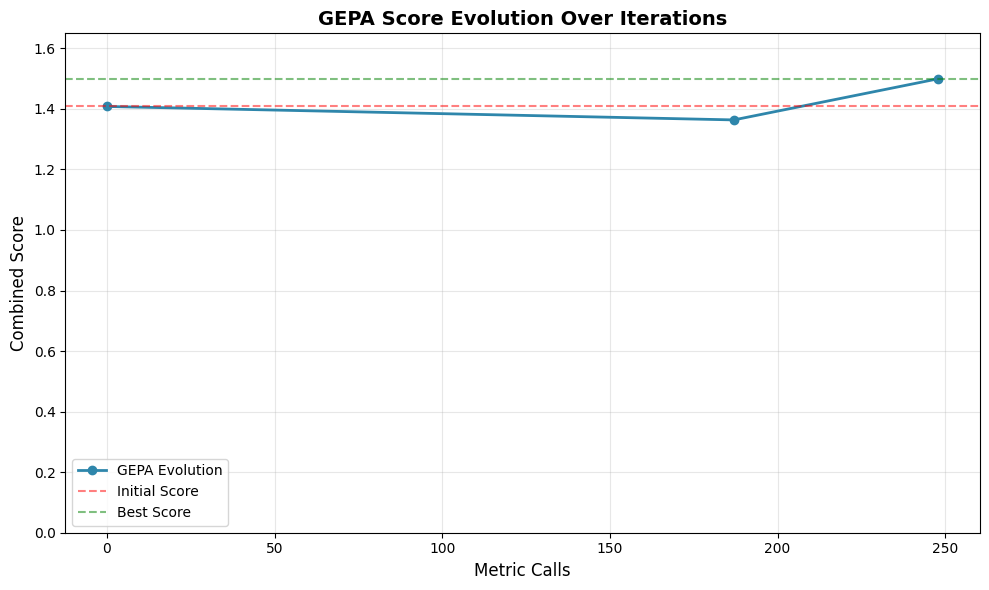

Initial Score: 1.4079
Best Score: 1.4995
Improvement: 6.51%
Total Candidates Evaluated: 3
Total Metric Calls: 501


In [21]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt

# Extract score progression over iterations
eval_counts = result.discovery_eval_counts
scores = result.val_aggregate_scores

# Sort by evaluation count to show progression
sorted_indices = sorted(range(len(eval_counts)), key=lambda i: eval_counts[i])
sorted_eval_counts = [eval_counts[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

# Create visualization of evolution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot: Score progression over metric calls
ax.plot(sorted_eval_counts, sorted_scores, "o-", linewidth=2, markersize=6, color="#2E86AB", label="GEPA Evolution")
ax.axhline(y=sorted_scores[0], color="r", linestyle="--", alpha=0.5, label="Initial Score")
ax.axhline(y=sorted_scores[-1], color="g", linestyle="--", alpha=0.5, label="Best Score")
ax.set_xlabel("Metric Calls", fontsize=12)
ax.set_ylabel("Combined Score", fontsize=12)
ax.set_title("GEPA Score Evolution Over Iterations", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_ylim([0, max(sorted_scores) * 1.1])

plt.tight_layout()
plt.show()

print(f"Initial Score: {sorted_scores[0]:.4f}")
print(f"Best Score: {sorted_scores[-1]:.4f}")
improvement = ((sorted_scores[-1] - sorted_scores[0]) / sorted_scores[0] * 100) if sorted_scores[0] > 0 else 0
print(f"Improvement: {improvement:.2f}%")
print(f"Total Candidates Evaluated: {len(result.candidates)}")
print(f"Total Metric Calls: {result.total_metric_calls}")

In [ ]:
# Re-evaluate the best candidate to get detailed metrics for comparison
evaluator_path = project_path / "evaluator.py"
spec = importlib.util.spec_from_file_location("evaluator", evaluator_path)
evaluator_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(evaluator_module)
evaluate = evaluator_module.evaluate

# Use the adapter's _construct_complete_program method to ensure
# the full program is constructed (including run_search() and other fixed code)
# (as best_candidate["program"] may only contain the evolved block)
best_program_text = result.best_candidate.get("program", "")
complete_program = adapter._construct_complete_program(best_program_text)

with tempfile.NamedTemporaryFile(mode="w", suffix=".py", delete=False) as f:
    f.write(complete_program)
    temp_program_path = f.name

best_result = evaluate(temp_program_path, trainset[0])
gepa_metrics = best_result.metrics

gepa_detailed = {
    "value_score": gepa_metrics.get("value_score", 0.0),
    "distance_score": gepa_metrics.get("distance_score", 0.0),
    "reliability_score": gepa_metrics.get("reliability_score", 0.0),
    "combined_score": gepa_metrics.get("combined_score", 0.0),
}

os.unlink(temp_program_path)

print("GEPA Best Candidate Detailed Metrics:")
print("=" * 50)
for metric, value in gepa_detailed.items():
    print(f"{metric}: {value:.4f}")

GEPA Best Candidate Detailed Metrics:
value_score: 0.9997
distance_score: 0.9995
reliability_score: 1.0000
combined_score: 1.4995


Let's compare this to the metrics as given by the OpenEvolve README.md for function minimization:

In [20]:
openevolve_metrics = {
    "value_score": 0.990,
    "distance_score": 0.921,
    "reliability_score": 1.000,
    "combined_score": 0.922,
}
print("OpenEvolve Best Candidate Detailed Metrics:")
print("=" * 50)
for metric, value in openevolve_metrics.items():
    print(f"{metric}: {value:.4f}")

OpenEvolve Best Candidate Detailed Metrics:
value_score: 0.9900
distance_score: 0.9210
reliability_score: 1.0000
combined_score: 0.9220


## Quick Reference: Before vs After

### Original OpenEvolve Evaluate Function:
```python
def evaluate(program_path: str) -> EvaluationResult:
    # Hard-coded problem parameters
    GLOBAL_MIN_X = -1.704
    GLOBAL_MIN_Y = 0.678
    GLOBAL_MIN_VALUE = -1.519
    
    # Run program multiple times (trials) and aggregate
    x_values = []
    y_values = []
    values = []
    for trial in range(num_trials):  # e.g., 10 trials
        result = program.run_search()
        x, y, value = result
        x_values.append(x)
        y_values.append(y)
        values.append(value)
    
    # Aggregate across all trials
    avg_value = np.mean(values)
    avg_distance = np.mean(distances)
    # ... calculate aggregated metrics ...
    
    # Return single aggregated result
    return EvaluationResult(metrics={...}, artifacts={...})
```

### Modified for EvolveAdapter:
```python
def evaluate(program_path: str, data_instance: dict) -> EvaluationResult:
    # Extract parameters from data instance
    # (Extraction method depends on the type of data_instance, e.g. dict for our function minimization example)
    GLOBAL_MIN_X = data_instance.get("global_min_x", -1.704)
    GLOBAL_MIN_Y = data_instance.get("global_min_y", 0.678)
    GLOBAL_MIN_VALUE = data_instance.get("global_min_value", -1.519)
    
    # Run program multiple times for this data instance
    for trial in range(num_trials):
        result = program.run_search()
        # ... aggregate results for this data instance ...
    
    # Return single result for this data instance
    return EvaluationResult(metrics={...}, artifacts={...})
```

## Notes:

1. **Data Instance Structure**: Each item in the batch (trainset) should represent a distinct evaluation instance. `data_instance` can be any type. Use whatever type suits your original project setup.

2. **Error Handling**: If evaluation fails for a specific data instance, return an `EvaluationResult` with error metrics rather than raising an exception.

4. **Metrics**: The `EvaluationResult` should include a `"combined_score"` metric in its `metrics` dict, as this is used by GEPA for optimization.

5. **Artifacts**: Use the `artifacts` field to store additional information. The adapter automatically uses these artifacts to create feedback for program improvement.

6. **Cascade Evaluation**: If your project uses cascade evaluation, remember to modify **all** stage functions (`evaluate_stage1`, `evaluate_stage2`, etc.) to accept `data_instance` and return a single `EvaluationResult` for that data instance. See Step 2 for details.

## Next Steps:

1. Modify your `evaluator.py` to accept `data_instance` parameter and return a single `EvaluationResult` for that data instance
2. **If using cascade evaluation**: Modify all stage functions (`evaluate_stage1`, `evaluate_stage2`, etc.) to accept `data_instance` and return a single `EvaluationResult` for that data instance
3. Test with a small batch to ensure everything works
4. Run GEPA optimization with your adapted project